In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Reshape, MaxPooling2D, Cropping2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import TensorBoard

C:\Users\Agostino\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Preprocessing:
#### legge i dati, prepara la Y (dummies), normalizza le X

In [2]:
# Import MNIST data
(X_train, Yt),(X_val,Yv) = mnist.load_data(path="mnist.npz")
# trasforma singola colonna Y in 10 dummies binarie
Y_val = to_categorical(Yv, num_classes=10)
Y_train = to_categorical(Yt, num_classes=10)
# normalizza i valori delle immagini
X_train = X_train / 255
X_val = X_val / 255
print("Dati letti.")
print(X_train.shape)
print(X_val.shape)

Dati letti.
(60000, 28, 28)
(10000, 28, 28)


#### i dati sono già divisi tra training e validation e sono arrays tridimensionali: (N, larghezza, altezza)

### Analisi con una rete neurale feedforward
### SCIKIT-LEARN  classificatore NN
class sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, ), activation=’relu’, solver=’adam’, alpha=0.0001, batch_size=’auto’, learning_rate=’constant’, learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)

MLPClassifier supports only the Cross-Entropy loss function / 
supports multi-class classification by applying Softmax as the output function

#### la rete feedforward richiede un input bidimensionale, ossia che ogni immagine sia una riga di 28*28=784 colonne
#### trasformo quindi le matrici dei dati

In [3]:
import numpy as np
XXX =np.reshape(X_train,(60000,784))
XVA =np.reshape(X_val,(10000,784))

#### definisco una rete con 4 strati interni (784, 512, 200, 200, 30, 10)
per impedire l'overfitting ho posto alpha=0.01 e abbassato leggermente beta_1 e beta_2.
L'algoritmo continua (fino a 200 iterazioni di default) fino a che la diminuzione della loss ne training non sia almeno tol=0.00001

In [4]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=0.01, hidden_layer_sizes=(512,200,200,30), beta_1=0.9,beta_2=0.95,
                    tol=0.00001, random_state=1)
clf.fit(XXX, Y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.95, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(512, 200, 200, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=1e-05, validation_fraction=0.1, verbose=False,
       warm_start=False)

Il modello utilizza 551.060 parametri: provate a contarli...

In [5]:
print("train:",clf.score(XXX,Y_train))
print("test:",clf.score(XVA,Y_val))

train: 0.9982833333333333
test: 0.9797


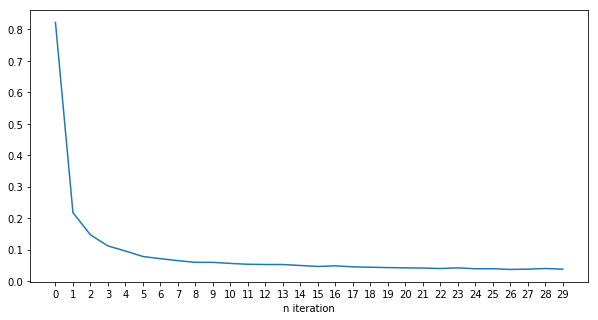

In [6]:
# Plot the loss curve for training 
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.xticks(range(len(clf.loss_curve_)))
ax.plot(clf.loss_curve_)
plt.xlabel("n iteration")
plt.show()

Le iterazioni si sono fermate alla 29, quindi non c'è stata riduzione del loss nel training negli ultimi steps
- ** attenzione ** non è early stopping, perchè?

---
## Convolutional Neural Networks
#### adesso applicheremo una rete neurale convoluzionale con KERAS/Tensorflow
#### Per definire il modello utilizzeremo la sintassi sequenziale
In the first layer, you must specify the expected input data shape: non utilizzeremo i datti flattened bensì le arrays originarie, a cui però dovremo aggiungere la dimensione del colore, anche se è solo 1, perché lo strato CONV2D si aspetta delle liste di arrays con dimensione (larghezza, altezza, colori). Il primo strato farà quindi la conversione (Reshape)

In [3]:
model = Sequential()

# This creates a model that includes two convolutional layer two maxpooling layer and two Dense layers
# includes cropping and dropout
# de-flatt each row
model.add(Reshape((28,28,1), input_shape=(28,28)))
model.add(Cropping2D(cropping=((2, 2), (2, 2))))
model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(10, activation='softmax'))
# per vedere il modello che abbiamo definito
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 24, 24, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
__________

## **Considerazioni:**
Il numero di parametri è simile alla rete precedente?
* le reti convoluzionali hanno pochi parametri

### Scelta dell'algoritmo di ottimizzazione: Adam, che di default ha i seguenti parametri:
keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#### Si effettua quindi la compilazione del modello

In [14]:
adam1 = Adam(lr=0.001, beta_1=0.9,beta_2=0.990, decay=1e-6, amsgrad=True)
model.compile(optimizer=adam1, loss='categorical_crossentropy', metrics=['accuracy'])

### use mnist.train to fit the model, test on mnist.test
#### abbiamo anche richiesto di registrare le informazioni per Tensorboard

In [16]:
tensorboard = TensorBoard(log_dir='log/run2', histogram_freq=5, write_graph=False, write_images=False)
model.fit(X_train, Y_train, epochs=5, validation_data=(X_val, Y_val),initial_epoch=0,
          batch_size=256, callbacks=[tensorboard])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 19s 315us/step - loss: 0.0191 - acc: 0.9939 - val_loss: 0.0214 - val_acc: 0.9925
Epoch 2/5
60000/60000 [==============================] - 17s 289us/step - loss: 0.0140 - acc: 0.9958 - val_loss: 0.0199 - val_acc: 0.9933
Epoch 3/5
60000/60000 [==============================] - 16s 273us/step - loss: 0.0107 - acc: 0.9965 - val_loss: 0.0193 - val_acc: 0.9936
Epoch 4/5
60000/60000 [==============================] - 17s 287us/step - loss: 0.0092 - acc: 0.9971 - val_loss: 0.0197 - val_acc: 0.9929
Epoch 5/5
60000/60000 [==============================] - 18s 297us/step - loss: 0.0073 - acc: 0.9976 - val_loss: 0.0221 - val_acc: 0.9939


#### commento:
Ad ogni **epoca** viene riportato il tempo impiegato, il loss e l'accuratezza sul training e sul test (validation), che possiamo comunque ricalcolare:

In [24]:
# evaluate the final model on test images
score = model.evaluate(X_val, Y_val, batch_size=128)
print(score)
yyy = model.predict(X_val,  batch_size=128)
from sklearn.metrics import confusion_matrix
ystim = np.argmax(yyy,axis=1)
print(confusion_matrix(Yv,ystim))

10000/10000 [==============================] - 7s 731us/step
[0.022101112502216712, 0.9939]
[[ 975    0    0    0    0    0    2    1    2    0]
 [   0 1130    0    0    0    1    1    1    1    1]
 [   0    0 1024    1    1    0    0    6    0    0]
 [   0    0    0 1004    0    5    0    0    0    1]
 [   0    0    0    0  975    0    2    0    0    5]
 [   0    0    0    2    0  887    1    2    0    0]
 [   1    1    0    0    1    1  954    0    0    0]
 [   0    2    0    1    0    0    0 1021    1    3]
 [   0    0    0    1    0    0    1    0  970    2]
 [   1    0    0    0    3    4    0    0    2  999]]


#### Expected accuracy on test set:  0.9944,      error rate %: 0.56
(with 100 epochs)

In [6]:
# save the fitted model
model.save("mnistmodel.h5")

### load a previously saved model and make again the predictions

In [ ]:
model2 = load_model("mnistmodel.h5")
yyy = model2.predict(X_val,  batch_size=128)
score = model2.evaluate(X_val, Y_val, batch_size=128)
print(score)